In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from utils import train
import time
from spn_3.spn import SPN
from utils import train, count_parameters, apply_lth_pruning, clean_weights, merge_weights

In [2]:
# Set the seed for PyTorch (CPU and GPU)
torch.manual_seed(42)

torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [3]:
#hyperparameters
batch_size = 128
learning_rate = 0.001
epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Get Dataset

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transforms: normalize CIFAR-10 images
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.247, 0.243, 0.261))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.247, 0.243, 0.261))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified


Minimal MLP

In [5]:
class Minimal_MLP(nn.Module):
    def __init__(self, input_size, hidden_dim, num_classes):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

MLP Baseline

In [6]:
# Model definition
class CIFAR10_MLP(nn.Module):
    def __init__(self, input_size, hidden_dims, num_classes):
        super().__init__()
        layers = []
        prev_dim = input_size
        for hdim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hdim))
            layers.append(nn.ReLU())
            prev_dim = hdim
        layers.append(nn.Linear(prev_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [7]:
num_classes = 10
MLP_hidden_dims = [256, 128, 64, 32]
total_nodes = sum(MLP_hidden_dims)
input_size = train_dataset[0][0].shape.numel()
num_samples = len(train_dataset)

In [8]:
model_0 = Minimal_MLP(input_size, sum(MLP_hidden_dims), num_classes).cuda()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optimizer = optim.Adam(model_0.parameters(), lr=learning_rate)

In [10]:
param_count_0 = count_parameters(model_0)

In [11]:
train_metrics_0, val_metrics_0 = train(model_0, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 0.5084 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.4189 Train_Loss: 1.6988 Validation_Accuracy: 0.4564 Validation_Loss: 1.5325
Epoch: 2 Total_Time: 0.5577 Average_Time_per_batch: 0.0014 Train_Accuracy: 0.4893 Train_Loss: 1.4705 Validation_Accuracy: 0.4977 Validation_Loss: 1.4435
Epoch: 3 Total_Time: 0.4552 Average_Time_per_batch: 0.0012 Train_Accuracy: 0.5215 Train_Loss: 1.3874 Validation_Accuracy: 0.4855 Validation_Loss: 1.4877
Epoch: 4 Total_Time: 0.5885 Average_Time_per_batch: 0.0015 Train_Accuracy: 0.5441 Train_Loss: 1.3146 Validation_Accuracy: 0.5136 Validation_Loss: 1.4174
Epoch: 5 Total_Time: 0.5115 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.5695 Train_Loss: 1.2484 Validation_Accuracy: 0.5045 Validation_Loss: 1.4848
Epoch: 6 Total_Time: 0.4986 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.5887 Train_Loss: 1.2022 Validation_Accuracy: 0.5052 Validation_Loss: 1.4953
Epoch: 7 Total_Time: 0.4466 Average_Time_per_batch: 0.0011 Train_Accuracy: 0.6039

In [12]:
model_1 = CIFAR10_MLP(input_size, MLP_hidden_dims, num_classes).to(device)

In [13]:
optimizer = optim.Adam(model_1.parameters(), lr=learning_rate)

In [14]:
param_count_1 = count_parameters(model_1)

In [15]:
train_metrics_1, val_metrics_1 = train(model_1, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 0.9910 Average_Time_per_batch: 0.0025 Train_Accuracy: 0.3891 Train_Loss: 1.7119 Validation_Accuracy: 0.4546 Validation_Loss: 1.5462
Epoch: 2 Total_Time: 1.0034 Average_Time_per_batch: 0.0026 Train_Accuracy: 0.4799 Train_Loss: 1.4726 Validation_Accuracy: 0.4928 Validation_Loss: 1.4411
Epoch: 3 Total_Time: 0.9383 Average_Time_per_batch: 0.0024 Train_Accuracy: 0.5195 Train_Loss: 1.3541 Validation_Accuracy: 0.5170 Validation_Loss: 1.3910
Epoch: 4 Total_Time: 0.9824 Average_Time_per_batch: 0.0025 Train_Accuracy: 0.5551 Train_Loss: 1.2658 Validation_Accuracy: 0.5120 Validation_Loss: 1.3749
Epoch: 5 Total_Time: 0.7753 Average_Time_per_batch: 0.0020 Train_Accuracy: 0.5803 Train_Loss: 1.1926 Validation_Accuracy: 0.5280 Validation_Loss: 1.3565
Epoch: 6 Total_Time: 0.8823 Average_Time_per_batch: 0.0023 Train_Accuracy: 0.6036 Train_Loss: 1.1275 Validation_Accuracy: 0.5356 Validation_Loss: 1.3496
Epoch: 7 Total_Time: 0.6361 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.6254

Minimal SPN

In [16]:
model_2 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes).cuda()
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)

In [17]:
param_count_2 = model_2.count_parameters()

In [18]:
train_metrics_2, val_metrics_2 = train(model_2, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 0.5219 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.3938 Train_Loss: 1.7898 Validation_Accuracy: 0.4222 Validation_Loss: 1.6745
Epoch: 2 Total_Time: 0.4636 Average_Time_per_batch: 0.0012 Train_Accuracy: 0.4611 Train_Loss: 1.6064 Validation_Accuracy: 0.4649 Validation_Loss: 1.6039
Epoch: 3 Total_Time: 0.4584 Average_Time_per_batch: 0.0012 Train_Accuracy: 0.4889 Train_Loss: 1.5282 Validation_Accuracy: 0.4510 Validation_Loss: 1.6263
Epoch: 4 Total_Time: 0.4833 Average_Time_per_batch: 0.0012 Train_Accuracy: 0.5176 Train_Loss: 1.4443 Validation_Accuracy: 0.4616 Validation_Loss: 1.6585
Epoch: 5 Total_Time: 0.4940 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.5359 Train_Loss: 1.3908 Validation_Accuracy: 0.4855 Validation_Loss: 1.6087
Epoch: 6 Total_Time: 0.5172 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.5586 Train_Loss: 1.3323 Validation_Accuracy: 0.4762 Validation_Loss: 1.7111
Epoch: 7 Total_Time: 0.4624 Average_Time_per_batch: 0.0012 Train_Accuracy: 0.5733

Maximal SPN

In [19]:
model_3 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes, minimal=False).cuda()
optimizer = optim.Adam(model_3.parameters(), lr=learning_rate)

In [20]:
param_count_3 = model_3.count_parameters()

In [21]:
train_metrics_3, val_metrics_3 = train(model_3, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 51.8562 Average_Time_per_batch: 0.1326 Train_Accuracy: 0.4042 Train_Loss: 1.7491 Validation_Accuracy: 0.4506 Validation_Loss: 1.6145
Epoch: 2 Total_Time: 51.7306 Average_Time_per_batch: 0.1323 Train_Accuracy: 0.4736 Train_Loss: 1.5391 Validation_Accuracy: 0.4709 Validation_Loss: 1.5619
Epoch: 3 Total_Time: 52.6433 Average_Time_per_batch: 0.1346 Train_Accuracy: 0.5149 Train_Loss: 1.4167 Validation_Accuracy: 0.4729 Validation_Loss: 1.6081
Epoch: 4 Total_Time: 52.3389 Average_Time_per_batch: 0.1339 Train_Accuracy: 0.5526 Train_Loss: 1.3042 Validation_Accuracy: 0.5055 Validation_Loss: 1.4829
Epoch: 5 Total_Time: 52.3520 Average_Time_per_batch: 0.1339 Train_Accuracy: 0.5892 Train_Loss: 1.2054 Validation_Accuracy: 0.5023 Validation_Loss: 1.5409
Epoch: 6 Total_Time: 52.1775 Average_Time_per_batch: 0.1334 Train_Accuracy: 0.6188 Train_Loss: 1.1135 Validation_Accuracy: 0.5178 Validation_Loss: 1.5515
Epoch: 7 Total_Time: 51.7913 Average_Time_per_batch: 0.1325 Train_Accuracy:

Free Weights SPN

In [22]:
model_4 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes, minimal=False, hidden_dims = MLP_hidden_dims + [num_classes]).cuda()
optimizer = optim.Adam(model_4.parameters(), lr=learning_rate)

In [23]:
param_count_4 = model_4.count_parameters()

In [24]:
train_metrics_4, val_metrics_4 = train(model_4, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 0.9433 Average_Time_per_batch: 0.0024 Train_Accuracy: 0.4037 Train_Loss: 1.7529 Validation_Accuracy: 0.4251 Validation_Loss: 1.6740
Epoch: 2 Total_Time: 1.0757 Average_Time_per_batch: 0.0028 Train_Accuracy: 0.4720 Train_Loss: 1.5563 Validation_Accuracy: 0.4636 Validation_Loss: 1.6202
Epoch: 3 Total_Time: 0.9229 Average_Time_per_batch: 0.0024 Train_Accuracy: 0.5057 Train_Loss: 1.4623 Validation_Accuracy: 0.4733 Validation_Loss: 1.5943
Epoch: 4 Total_Time: 1.0629 Average_Time_per_batch: 0.0027 Train_Accuracy: 0.5395 Train_Loss: 1.3637 Validation_Accuracy: 0.4812 Validation_Loss: 1.6221
Epoch: 5 Total_Time: 1.1628 Average_Time_per_batch: 0.0030 Train_Accuracy: 0.5705 Train_Loss: 1.2779 Validation_Accuracy: 0.4879 Validation_Loss: 1.6207
Epoch: 6 Total_Time: 1.0295 Average_Time_per_batch: 0.0026 Train_Accuracy: 0.5924 Train_Loss: 1.2063 Validation_Accuracy: 0.4972 Validation_Loss: 1.6100
Epoch: 7 Total_Time: 1.0719 Average_Time_per_batch: 0.0027 Train_Accuracy: 0.6138

Maximal SPN with pruning

In [34]:
model_5 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes, minimal=False).cuda()
optimizer = optim.Adam(model_5.parameters(), lr=learning_rate)

In [35]:
percent = 0.99
rounds = 10
pruning_epochs = 2

pruning_start = time.time()
new_weights = apply_lth_pruning(model_5, train_loader, test_loader, pruning_epochs, optimizer, criterion, percent, rounds)
pruning_time = time.time() - pruning_start

Initial Validation Phase


Epoch: 1 Total_Time: 52.2054 Average_Time_per_batch: 0.1335 Train_Accuracy: 0.4038 Train_Loss: 1.7495 Validation_Accuracy: 0.4416 Validation_Loss: 1.6464
Epoch: 2 Total_Time: 52.4226 Average_Time_per_batch: 0.1341 Train_Accuracy: 0.4746 Train_Loss: 1.5417 Validation_Accuracy: 0.4676 Validation_Loss: 1.5598

Pruning Round: 1
Epoch: 1 Total_Time: 51.6083 Average_Time_per_batch: 0.1320 Train_Accuracy: 0.4118 Train_Loss: 1.7144 Validation_Accuracy: 0.4497 Validation_Loss: 1.6014
Epoch: 2 Total_Time: 52.1764 Average_Time_per_batch: 0.1334 Train_Accuracy: 0.4807 Train_Loss: 1.5147 Validation_Accuracy: 0.4739 Validation_Loss: 1.6010

Pruning Round: 2
Epoch: 1 Total_Time: 52.2782 Average_Time_per_batch: 0.1337 Train_Accuracy: 0.4188 Train_Loss: 1.6921 Validation_Accuracy: 0.4330 Validation_Loss: 1.6481
Epoch: 2 Total_Time: 52.0761 Average_Time_per_batch: 0.1332 Train_Accuracy: 0.4861 Train_Loss: 1.5063 Validation_Accuracy: 0.4619 Validation_Loss: 1.5522

In [36]:
cleaned_weights = clean_weights(new_weights, input_size)
merged_weights = merge_weights(cleaned_weights, input_size, num_classes)

Empty Blocks:  []


In [37]:
hidden_dims_pruned = [weight.shape[0] for weight in merged_weights]
print("Pruned Dimensions: ", hidden_dims_pruned)
print("Pruning Time: ", pruning_time)

Pruned Dimensions:  [3, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 3, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 3, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1

In [38]:
model_5 = SPN(input_size, sum(hidden_dims_pruned), num_classes, minimal=False, hidden_dims=hidden_dims_pruned).cuda()
optimizer = optim.Adam(model_5.parameters(), lr=learning_rate)

In [39]:
param_count_5 = model_5.count_parameters()

In [40]:
train_metrics_5, val_metrics_5 = train(model_5, train_loader, test_loader, epochs, optimizer, criterion)


Epoch: 1 Total_Time: 44.3539 Average_Time_per_batch: 0.1134 Train_Accuracy: 0.4035 Train_Loss: 1.7444 Validation_Accuracy: 0.4401 Validation_Loss: 1.6237
Epoch: 2 Total_Time: 43.9861 Average_Time_per_batch: 0.1125 Train_Accuracy: 0.4773 Train_Loss: 1.5285 Validation_Accuracy: 0.4668 Validation_Loss: 1.5603
Epoch: 3 Total_Time: 44.0872 Average_Time_per_batch: 0.1128 Train_Accuracy: 0.5183 Train_Loss: 1.4097 Validation_Accuracy: 0.4892 Validation_Loss: 1.5095
Epoch: 4 Total_Time: 43.9660 Average_Time_per_batch: 0.1124 Train_Accuracy: 0.5547 Train_Loss: 1.3060 Validation_Accuracy: 0.4975 Validation_Loss: 1.5228
Epoch: 5 Total_Time: 43.8257 Average_Time_per_batch: 0.1121 Train_Accuracy: 0.5908 Train_Loss: 1.1969 Validation_Accuracy: 0.4928 Validation_Loss: 1.5617
Epoch: 6 Total_Time: 44.0309 Average_Time_per_batch: 0.1126 Train_Accuracy: 0.6219 Train_Loss: 1.1060 Validation_Accuracy: 0.5075 Validation_Loss: 1.5885
Epoch: 7 Total_Time: 43.7693 Average_Time_per_batch: 0.1119 Train_Accuracy:

Plot Training and Test Accuracies Across Epochs

In [41]:
import numpy as np
import matplotlib.pyplot as plt

train_acc_0 = train_metrics_0[:, 2] / (num_samples / batch_size)
train_acc_1 = train_metrics_1[:, 2] / (num_samples / batch_size)
train_acc_2 = train_metrics_2[:, 2] / (num_samples / batch_size)
train_acc_3 = train_metrics_3[:, 2] / (num_samples / batch_size)
train_acc_4 = train_metrics_4[:, 2] / (num_samples / batch_size)
train_acc_5 = train_metrics_5[:, 2] / (num_samples / batch_size)

epochs = np.arange(1, epochs + 1)

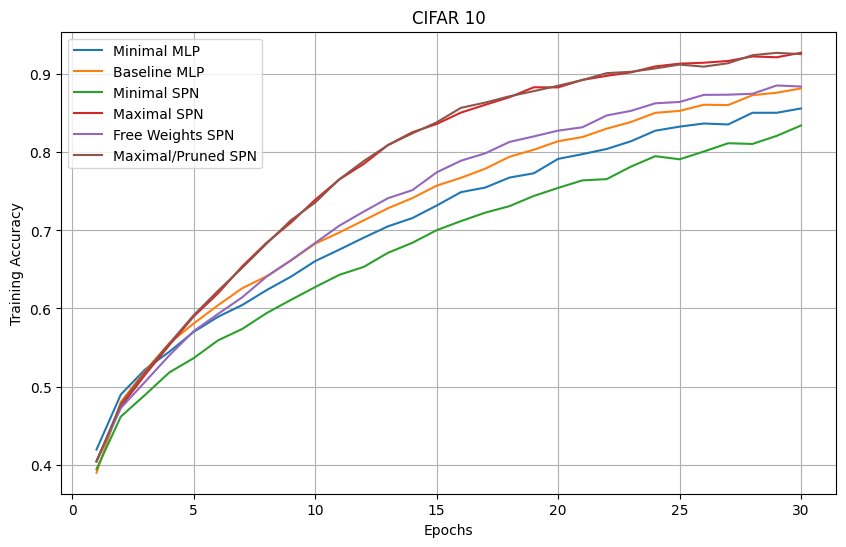

In [42]:
# Plot the training accuracy of all 5 models
plt.figure(figsize=(10, 6))

plt.plot(epochs, train_acc_0, label='Minimal MLP')
plt.plot(epochs, train_acc_1, label='Baseline MLP')
plt.plot(epochs, train_acc_2, label='Minimal SPN')
plt.plot(epochs, train_acc_3, label='Maximal SPN')
plt.plot(epochs, train_acc_4, label='Free Weights SPN')
plt.plot(epochs, train_acc_5, label='Maximal/Pruned SPN')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('CIFAR 10')

# Adding a legend to distinguish the models
plt.legend()

# Show the plot
plt.grid(True)

#save the plot
plt.savefig('results/CIFAR_10/training_accuracy_plot.png')  # Save as PNG file
plt.show()

In [43]:
test_acc_0 = val_metrics_0[:, 1]
test_acc_1 = val_metrics_1[:, 1]
test_acc_2 = val_metrics_2[:, 1]
test_acc_3 = val_metrics_3[:, 1]
test_acc_4 = val_metrics_4[:, 1]
test_acc_5 = val_metrics_5[:, 1]

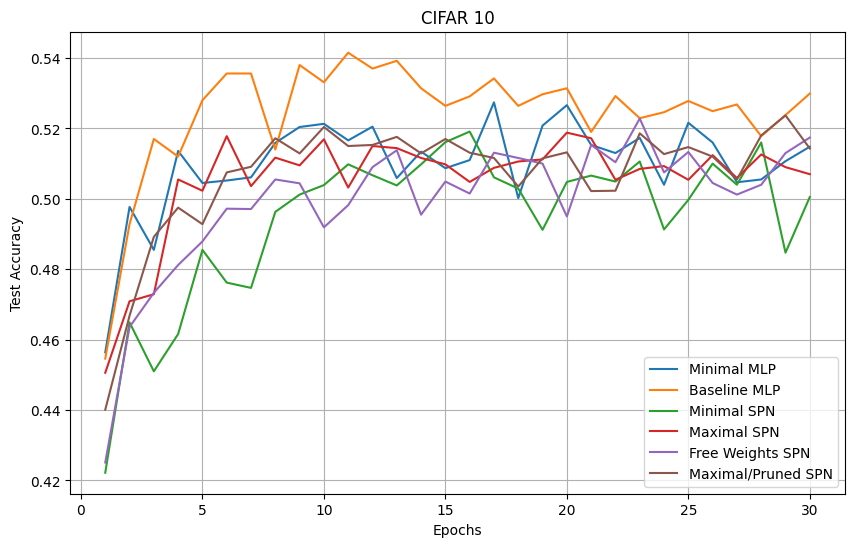

In [44]:
# Plot the training accuracy of all 5 models
plt.figure(figsize=(10, 6))

plt.plot(epochs, test_acc_0, label='Minimal MLP')
plt.plot(epochs, test_acc_1, label='Baseline MLP')
plt.plot(epochs, test_acc_2, label='Minimal SPN')
plt.plot(epochs, test_acc_3, label='Maximal SPN')
plt.plot(epochs, test_acc_4, label='Free Weights SPN')
plt.plot(epochs, test_acc_5, label='Maximal/Pruned SPN')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('CIFAR 10')

# Adding a legend to distinguish the models
plt.legend()

# Show the plot
plt.grid(True)

#save the plot
plt.savefig('results/CIFAR_10/test_accuracy_plot.png')  # Save as PNG file
plt.show()

In [45]:
# List of all test accuracies
test_accuracies = [test_acc_0, test_acc_1, test_acc_2, test_acc_3, test_acc_4, test_acc_5]

# Find the index of the best (maximum) accuracy for each model
best_accuracy_indices = [np.argmax(acc) + 1 for acc in test_accuracies]

In [46]:
time_to_best_acc_0 = train_metrics_0[:best_accuracy_indices[0], 0].sum()
time_to_best_acc_1 = train_metrics_1[:best_accuracy_indices[1], 0].sum()
time_to_best_acc_2 = train_metrics_2[:best_accuracy_indices[2], 0].sum()
time_to_best_acc_3 = train_metrics_3[:best_accuracy_indices[3], 0].sum()
time_to_best_acc_4 = train_metrics_4[:best_accuracy_indices[4], 0].sum()
time_to_best_acc_5 = train_metrics_5[:best_accuracy_indices[5], 0].sum()

best_test_acc_0 = test_acc_0[best_accuracy_indices[0] - 1]
best_test_acc_1 = test_acc_1[best_accuracy_indices[1] - 1]
best_test_acc_2 = test_acc_2[best_accuracy_indices[2] - 1]
best_test_acc_3 = test_acc_3[best_accuracy_indices[3] - 1]
best_test_acc_4 = test_acc_4[best_accuracy_indices[4] - 1]
best_test_acc_5 = test_acc_5[best_accuracy_indices[5] - 1]

In [47]:
summary_0 = ['Minimal MLP', param_count_0, best_test_acc_0, time_to_best_acc_0, best_test_acc_0 / time_to_best_acc_0]
summary_1 = ['Baseline MLP', param_count_1, best_test_acc_1, time_to_best_acc_1, best_test_acc_1 / time_to_best_acc_1]
summary_2 = ['Minimal SPN', param_count_2, best_test_acc_2, time_to_best_acc_2, best_test_acc_2 / time_to_best_acc_2]
summary_3 = ['Maximal SPN', param_count_3, best_test_acc_3, time_to_best_acc_3, best_test_acc_3 / time_to_best_acc_3]
summary_4 = ['Free Weights SPN', param_count_4, best_test_acc_4, time_to_best_acc_4, best_test_acc_4 / time_to_best_acc_4]
summary_5 = ['Maximal/Pruned SPN', param_count_5, best_test_acc_5, time_to_best_acc_5, best_test_acc_5 / time_to_best_acc_5]

In [48]:
import pandas as pd

# Combine all summaries into a list of lists (each summary as a row)
summaries = [summary_0, summary_1, summary_2, summary_3, summary_4, summary_5]

# Create a DataFrame
df = pd.DataFrame(summaries, columns=['Model', 'Parameter Count', 'Best Test Accuracy', 'Time to Best Test Accuracy', 'Efficiency'])

# Set the display options to allow for better fitting
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Increase the width so it can fit more columns
pd.set_option('display.max_colwidth', None)  # Allow unlimited column width

# Now when you print the DataFrame, it will be displayed as a continuous table
print(df)

                Model  Parameter Count  Best Test Accuracy  Time to Best Test Accuracy  Efficiency
0         Minimal MLP          1479850              0.5274                    8.440949    0.062481
1        Baseline MLP           830250              0.5415                    9.781320    0.055361
2         Minimal SPN          1510570              0.5191                    7.582823    0.068457
3         Maximal SPN          1625575              0.5188                 1042.935568    0.000497
4    Free Weights SPN          1582250              0.5228                   24.148535    0.021649
5  Maximal/Pruned SPN          1625474              0.5237                 1279.211751    0.000409


In [49]:
df.to_csv('results/CIFAR_10/model_summary.csv', index=False)